In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
df_d = pd.read_csv("Dutch_paydiff_norm.csv")
df_h = pd.read_csv("Honolulu_paydiff_norm.csv")
# df_d = df_d[df_d["subsession.round_number"] > 2]
# df_h = df_h[df_h["subsession.round_number"] > 2]

### Three price dynamics in Honolulu

In [3]:
def priceDynamics(rmin, rmax, tol, is_actual):
    dict_dynamics = {
        (2, 0.009): dict(),
        (2, 0.019): dict(),
        (5, 0.009): dict(),
        (5, 0.019): dict(),
    }
    tmpdf = df_h[(df_h["subsession.round_number"] >= rmin) & (df_h["subsession.round_number"] <= rmax)]
    for index, row in tmpdf.iterrows():
        key1 = (int(row["session.config.name"][1]), row["session.config.discount_b"])
        key2 = (row["session.code"], row["subsession.round_number"], row["group.id_in_subsession"])
        if key2 not in dict_dynamics[key1].keys():
            start_price = row["session.config.start_price"]
            
            # actual price dynamics
            if is_actual:
                dutch_final_price = row["group.dutch_final_price"]
                num_contestant = row["group.have_contest_winner"]
            # predicted price dynamics
            else:
                dutch_final_price = row["predict.group.dutch_final_price"]
                num_contestant = df_h[(df_h["session.code"] == row["session.code"]) & (df_h["subsession.round_number"] == row["subsession.round_number"]) & (df_h["group.id_in_subsession"] == row["group.id_in_subsession"])]["predict.player.contest_status"].sum()

            if (start_price - dutch_final_price <= tol):
                if (num_contestant >= 2):
                    dict_dynamics[key1][key2] = "E"
                else:
                    dict_dynamics[key1][key2] = "D"
            else:
                if (num_contestant >=2):
                    dict_dynamics[key1][key2] = "H"
                else:
                    dict_dynamics[key1][key2] = "D"
    print("2H")
    print(pd.value_counts(list(dict_dynamics[(2, 0.019)].values())))
    print("2L")
    print(pd.value_counts(list(dict_dynamics[(2, 0.009)].values())))
    print("5H")
    print(pd.value_counts(list(dict_dynamics[(5, 0.019)].values())))
    print("5L")
    print(pd.value_counts(list(dict_dynamics[(5, 0.009)].values())))

In [4]:
priceDynamics(3, 30, 2, is_actual=1)

2H
H    222
D    113
E     25
dtype: int64
2L
H    250
D     77
E     15
dtype: int64
5H
H    135
E     48
D     27
dtype: int64
5L
H    115
E     56
D     25
dtype: int64


In [5]:
def signedRankTest(rmin, rmax, tol):
    tmpdf = df_h[(df_h["subsession.round_number"] >= rmin) & (df_h["subsession.round_number"] <= rmax)]
    actual_dict = dict()
    predict_dict = dict()
    for key in set(tmpdf["session.code"]):
        actual_dict[key] = dict()
        predict_dict[key] = dict()
    tmplist = []

    for index, row in tmpdf.iterrows():
        key1 = row["session.code"]
        key2 = (row["subsession.round_number"], row["group.id_in_subsession"])

        if key2 not in actual_dict[key1].keys():
            start_price = row["session.config.start_price"]

            actual_dutch_final_price = row["group.dutch_final_price"]
            actual_num_contestant = row["group.have_contest_winner"]
            if (start_price - actual_dutch_final_price <= tol):
                if (actual_num_contestant >= 2):
                    actual_dict[key1][key2] = "E"
                else:
                    actual_dict[key1][key2] = "D"
            else:
                if (actual_num_contestant >=2):
                    actual_dict[key1][key2] = "H"
                else:
                    actual_dict[key1][key2] = "D"
            
            predict_dutch_final_price = row["predict.group.dutch_final_price"]
            predict_num_contestant = df_h[(df_h["session.code"] == row["session.code"]) & (df_h["subsession.round_number"] == row["subsession.round_number"]) & (df_h["group.id_in_subsession"] == row["group.id_in_subsession"])]["predict.player.contest_status"].sum()
            if (start_price - predict_dutch_final_price <= tol):
                if (predict_num_contestant >= 2):
                    predict_dict[key1][key2] = "E"
                else:
                    predict_dict[key1][key2] = "D"
            else:
                if (predict_num_contestant >=2):
                    predict_dict[key1][key2] = "H"
                else:
                    predict_dict[key1][key2] = "D"

    for code in actual_dict.keys():
        actual_H = sum(1 for x in actual_dict[code].values() if x == "H")
        actual_D = sum(1 for x in actual_dict[code].values() if x == "D")
        actual_E = sum(1 for x in actual_dict[code].values() if x == "E")
        actual_all = len(actual_dict[code])
        predict_H = sum(1 for x in predict_dict[code].values() if x == "H")
        predict_D = sum(1 for x in predict_dict[code].values() if x == "D")
        predict_E = sum(1 for x in predict_dict[code].values() if x == "E")
        predict_all = len(predict_dict[code])
        tmplist.append([
            code,
            actual_H / actual_all, predict_H / predict_all,
            actual_D / actual_all, predict_D / predict_all,
            actual_E / actual_all, predict_E / predict_all,
        ])
    testdf = pd.DataFrame(tmplist, columns=["treatment", "aH", "pH", "aD", "pD", "aE", "pE"])

    print("H ratio test")
    print(stats.wilcoxon(testdf["aH"], testdf["pH"], alternative="two-sided"))
    print("D ratio test")
    print(stats.wilcoxon(testdf["aD"], testdf["pD"], alternative="two-sided"))
    print("E ratio test")
    print(stats.wilcoxon(testdf["aE"], testdf["pE"], alternative="two-sided"))

In [6]:
signedRankTest(3, 30, 2)

H ratio test
WilcoxonResult(statistic=1.0, pvalue=0.0001220703125)
D ratio test
WilcoxonResult(statistic=22.5, pvalue=0.05947202707400474)
E ratio test
WilcoxonResult(statistic=0.0, pvalue=0.0009815397525216685)


c:\Program Files\Python39\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [81]:
def signedRankTestByTreatment(rmin, rmax, tol, n, b):
    tmpdf = df_h[
        (df_h["subsession.round_number"] >= rmin) 
        & (df_h["subsession.round_number"] <= rmax) 
        & (df_h["session.config.name"].str.contains("0"+str(n))) 
        #& (df_h["session.config.discount_b"] == b)
    ]
    actual_dict = dict()
    predict_dict = dict()
    for key in set(tmpdf["session.code"]):
        actual_dict[key] = dict()
        predict_dict[key] = dict()
    tmplist = []

    for index, row in tmpdf.iterrows():
        key1 = row["session.code"]
        key2 = (row["subsession.round_number"], row["group.id_in_subsession"])

        if key2 not in actual_dict[key1].keys():
            start_price = row["session.config.start_price"]

            actual_dutch_final_price = row["group.dutch_final_price"]
            actual_num_contestant = row["group.have_contest_winner"]
            if (start_price - actual_dutch_final_price <= tol):
                if (actual_num_contestant >= 2):
                    actual_dict[key1][key2] = "E"
                else:
                    actual_dict[key1][key2] = "D"
            else:
                if (actual_num_contestant >=2):
                    actual_dict[key1][key2] = "H"
                else:
                    actual_dict[key1][key2] = "D"
            
            predict_dutch_final_price = row["predict.group.dutch_final_price"]
            predict_num_contestant = df_h[(df_h["session.code"] == row["session.code"]) & (df_h["subsession.round_number"] == row["subsession.round_number"]) & (df_h["group.id_in_subsession"] == row["group.id_in_subsession"])]["predict.player.contest_status"].sum()
            if (start_price - predict_dutch_final_price <= tol):
                if (predict_num_contestant >= 2):
                    predict_dict[key1][key2] = "E"
                else:
                    predict_dict[key1][key2] = "D"
            else:
                if (predict_num_contestant >=2):
                    predict_dict[key1][key2] = "H"
                else:
                    predict_dict[key1][key2] = "D"

    for code in actual_dict.keys():
        actual_H = sum(1 for x in actual_dict[code].values() if x == "H")
        actual_D = sum(1 for x in actual_dict[code].values() if x == "D")
        actual_E = sum(1 for x in actual_dict[code].values() if x == "E")
        actual_all = len(actual_dict[code])
        predict_H = sum(1 for x in predict_dict[code].values() if x == "H")
        predict_D = sum(1 for x in predict_dict[code].values() if x == "D")
        predict_E = sum(1 for x in predict_dict[code].values() if x == "E")
        predict_all = len(predict_dict[code])
        tmplist.append([
            code,
            actual_H / actual_all, predict_H / predict_all,
            actual_D / actual_all, predict_D / predict_all,
            actual_E / actual_all, predict_E / predict_all,
        ])
    testdf= pd.DataFrame(tmplist, columns=["treatment", "aH", "pH", "aD", "pD", "aE", "pE"])

    print([n, b, len(testdf)])
    print("H ratio test")
    print(stats.wilcoxon(testdf["aH"], testdf["pH"], alternative="greater"))
    print("D ratio test")
    print(stats.wilcoxon(testdf["aD"], testdf["pD"], alternative="less"))
    print("E ratio test")
    print(stats.wilcoxon(testdf["aE"], testdf["pE"], alternative="less"))

In [84]:
signedRankTestByTreatment(3, 30, 2, 2, 0.009)

[2, 0.009, 8]
H ratio test
WilcoxonResult(statistic=36.0, pvalue=0.00390625)
D ratio test
WilcoxonResult(statistic=11.0, pvalue=0.19140625)
E ratio test
WilcoxonResult(statistic=0.0, pvalue=0.00390625)


### SD & WD decisions

In [35]:
# strictly dominated decision: bid above the item value in pure Dutch auctions
def tableSD(n, b, rmin, rmax, qmin, qmax, tol):
    tmpdf = df_d[df_d["session.config.name"].str.contains(str(n) + "_") & (df_d["session.config.discount_b"] == b) & (df_d["subsession.round_number"] >= rmin) & (df_d["subsession.round_number"] <= rmax)]
    qlist = tmpdf["paydiff_pct"].unique()
    tmpdf = tmpdf[(tmpdf["paydiff_pct"] >= np.quantile(qlist, qmin)) & (tmpdf["paydiff_pct"] <= np.quantile(qlist, qmax))]
    
    tmpdf_bid = tmpdf[tmpdf["player.is_dutch_winner"] == 1]
    
    num_all_bid = len(tmpdf_bid)
    num_sd_bid = np.sum(tmpdf_bid.apply(lambda x: x["group.dutch_final_price"] > x["player.item_value"] + tol, axis=1))
    print("n_d\tn_d_sd\tpct")
    print("%d\t%d\t%.3f" % (num_all_bid, num_sd_bid, num_sd_bid / num_all_bid))

In [12]:
tableSD(2, 0.019, 3, 30, 0.501, 1, 2)
tableSD(2, 0.009, 3, 30, 0.501, 1, 2)
tableSD(5, 0.019, 3, 30, 0.501, 1, 2)
tableSD(5, 0.009, 3, 30, 0.501, 1, 2)

n_d	n_d_sd	pct
189	0	0.000
n_d	n_d_sd	pct
167	0	0.000
n_d	n_d_sd	pct
117	0	0.000
n_d	n_d_sd	pct
98	0	0.000


In [8]:
tableSD(2, 0.019, 3, 30, 0, 0.5, 2)
tableSD(2, 0.009, 3, 30, 0, 0.5, 2)
tableSD(5, 0.019, 3, 30, 0, 0.5, 2)
tableSD(5, 0.009, 3, 30, 0, 0.5, 2)

n_d	n_d_sd	pct
165	9	0.055
n_d	n_d_sd	pct
171	1	0.006
n_d	n_d_sd	pct
93	2	0.022
n_d	n_d_sd	pct
98	15	0.153


In [21]:
def undominatedRatioDutch(df, qmin, qmax, tol):
    qlist = df["paydiff_pct"].unique()
    tmpdf = df[(df["paydiff_pct"] >= np.quantile(qlist, qmin)) & (df["paydiff_pct"] <= np.quantile(qlist, qmax))]

    tmpdf_bid = tmpdf[tmpdf["player.is_dutch_winner"] == 1]
    
    num_all_bid = len(tmpdf_bid)
    num_sd_bid = np.sum(tmpdf_bid.apply(lambda x: x["group.dutch_final_price"] > x["player.item_value"] + tol, axis=1))

    return (num_all_bid - num_sd_bid) / num_all_bid

def signedRankUndominatedDutch(n, b, rmin, rmax, tol):
    tmpdf = df_d[
        #(df_d["session.config.name"].str.contains(str(n) + "_")) 
        #& (df_d["session.config.discount_b"] == b) 
        (df_d["subsession.round_number"] >= rmin) 
        & (df_d["subsession.round_number"] <= rmax)
    ]
    tmplist = []
    for code in set(tmpdf["session.code"]):
        dfsession = tmpdf[tmpdf["session.code"] == code]
        ud_bid_top = undominatedRatioDutch(dfsession, 0.501, 1, tol)
        ud_bid_bot = undominatedRatioDutch(dfsession, 0, 0.5, tol)
        tmplist.append([code, ud_bid_top, ud_bid_bot])
    testdf= pd.DataFrame(tmplist, columns=["treatment", "top", "bot",])

    print([n, b, len(testdf)])
    print(stats.wilcoxon(testdf["top"], testdf["bot"], alternative="greater"))
    # print(stats.wilcoxon(testdf["top"], testdf["bot"], alternative="two-sided"))

In [23]:
signedRankUndominatedDutch(5, 0.019, 3, 30, 2)

[5, 0.019, 15]
WilcoxonResult(statistic=45.0, pvalue=0.003816220824102754)


c:\Program Files\Python39\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Program Files\Python39\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [42]:
# weakly dominated decision: in Honolulu auctions, Dutch/contest stage bid above the item value, English stage early/late dropout
def tableWD(n, b, rmin, rmax, qmin, qmax, tol):
    tmpdf = df_h[df_h["session.config.name"].str.contains(str(n) + "_") & (df_h["session.config.discount_b"] == b) & (df_h["subsession.round_number"] >= rmin) & (df_h["subsession.round_number"] <= rmax)]
    qlist = tmpdf["paydiff_pct"].unique()
    tmpdf = tmpdf[(tmpdf["paydiff_pct"] >= np.quantile(qlist, qmin)) & (tmpdf["paydiff_pct"] <= np.quantile(qlist, qmax))]
    
    tmpdf_dbid = tmpdf[tmpdf["player.is_dutch_winner"] == 1]
    tmpdf_cbid = tmpdf[(tmpdf["player.is_dutch_winner"] == 0) & (tmpdf["player.contest_status"] == 1)]
    tmpdf_cleave = tmpdf[(tmpdf["player.is_dutch_winner"] == 0) & (tmpdf["player.contest_status"] != 1)]
    tmpdf_eleave = tmpdf[(tmpdf["group.have_contest_winner"] > 1) & (tmpdf["player.contest_status"] == 1)]

    # dutch stage bid
    num_all_dbid = len(tmpdf_dbid)
    num_wd_dbid = np.sum(tmpdf_dbid.apply(lambda x: x["group.dutch_final_price"] > x["player.item_value"] + tol, axis=1))

    # contest stage bid
    num_all_cbid = len(tmpdf_cbid)
    num_cbid_above = np.sum(tmpdf_cbid.apply(lambda x: x["group.dutch_final_price"] > x["player.item_value"] + tol, axis=1))

    # contest stage leave
    num_all_cleave = len(tmpdf_cleave)
    num_cleave_below = np.sum(tmpdf_cleave.apply(lambda x: x["group.dutch_final_price"] < (x["player.item_value"] - tol), axis=1))

    # english stage leave
    num_all_eleave = len(tmpdf_eleave)
    num_eleave_below = np.sum(tmpdf_eleave.apply(lambda x: (x["player.dropout_price"] < (x["player.item_value"] - tol)) & (x["player.is_final_winner"] == 0), axis=1))
    num_eleave_above = np.sum(tmpdf_eleave.apply(lambda x: x["player.dropout_price"] > (x["player.item_value"] + tol), axis=1))
    
    # final outcome (dropout decision)
    num_all_drop = len(tmpdf)
    num_drop_below = np.sum(tmpdf.apply(lambda x: (x["player.dropout_price"] < x["player.item_value"] - tol) & (x["player.is_final_winner"] == 0), axis=1))
    num_actual_regret = np.sum(tmpdf.apply(lambda x: (x["group.final_price"] < x["player.item_value"] - tol) & (x["player.is_final_winner"] == 0), axis=1))
    num_drop_above = np.sum(tmpdf.apply(lambda x: (x["player.dropout_price"] > x["player.item_value"] + tol) & (x["player.contest_status"] == 1), axis=1))
    num_actual_loss = np.sum(tmpdf.apply(lambda x: (x["group.final_price"] > x["player.item_value"] + tol) & (x["player.is_final_winner"] == 1), axis=1))
    
    print("n_d\tn_d_wd\tpct\tn_cl\tn_cl_b\tpct\tn_cb\tn_cb_a\tpct\tn_e\tn_e_b\tpct\tn_e_a\tpct\t")
    print("%d\t%d\t%.3f\t%d\t%d\t%.3f\t%d\t%d\t%.3f\t%d\t%d\t%.3f\t%d\t%.3f\t" % (
        num_all_dbid, num_wd_dbid, num_wd_dbid / num_all_dbid,
        num_all_cleave, num_cleave_below, num_cleave_below / num_all_cleave, num_all_cbid, num_cbid_above, num_cbid_above / num_all_cbid,
        num_all_eleave, num_eleave_below, num_eleave_below / num_all_eleave, num_eleave_above, num_eleave_above / num_all_eleave,
        
    ))
    print("n_dp\tn_dp_b\tpct\tn_dp_bb\tpct\tn_dp_a\tpct\tn_dp_aa\tpct")
    print("%d\t%d\t%.3f\t%d\t%.3f\t%d\t%.3f\t%d\t%.3f" % (
        num_all_drop,
        num_drop_below, num_drop_below / num_all_drop, num_actual_regret, num_actual_regret / num_drop_below,
        num_drop_above, num_drop_above / num_all_drop, num_actual_loss, num_actual_loss / num_drop_above,
    ))
    print("")

In [43]:
tableWD(2, 0.019, rmin=3, rmax=30, qmin=0.501, qmax=1, tol=2)
tableWD(2, 0.009, rmin=3, rmax=30, qmin=0.501, qmax=1, tol=2)
tableWD(5, 0.019, rmin=3, rmax=30, qmin=0.501, qmax=1, tol=2)
tableWD(5, 0.009, rmin=3, rmax=30, qmin=0.501, qmax=1, tol=2)

n_d	n_d_wd	pct	n_cl	n_cl_b	pct	n_cb	n_cb_a	pct	n_e	n_e_b	pct	n_e_a	pct	
181	0	0.000	65	7	0.108	114	0	0.000	225	16	0.071	5	0.022	
n_dp	n_dp_b	pct	n_dp_bb	pct	n_dp_a	pct	n_dp_aa	pct
360	23	0.064	23	1.000	5	0.014	0	0.000

n_d	n_d_wd	pct	n_cl	n_cl_b	pct	n_cb	n_cb_a	pct	n_e	n_e_b	pct	n_e_a	pct	
147	0	0.000	41	12	0.293	154	0	0.000	264	26	0.098	3	0.011	
n_dp	n_dp_b	pct	n_dp_bb	pct	n_dp_a	pct	n_dp_aa	pct
342	38	0.111	38	1.000	3	0.009	1	0.333

n_d	n_d_wd	pct	n_cl	n_cl_b	pct	n_cb	n_cb_a	pct	n_e	n_e_b	pct	n_e_a	pct	
97	1	0.010	236	7	0.030	155	5	0.032	238	13	0.055	7	0.029	
n_dp	n_dp_b	pct	n_dp_bb	pct	n_dp_a	pct	n_dp_aa	pct
488	20	0.041	13	0.650	7	0.014	0	0.000

n_d	n_d_wd	pct	n_cl	n_cl_b	pct	n_cb	n_cb_a	pct	n_e	n_e_b	pct	n_e_a	pct	
99	1	0.010	220	6	0.027	157	1	0.006	244	8	0.033	10	0.041	
n_dp	n_dp_b	pct	n_dp_bb	pct	n_dp_a	pct	n_dp_aa	pct
476	14	0.029	7	0.500	10	0.021	1	0.100



In [44]:
tableWD(2, 0.019, rmin=3, rmax=30, qmin=0, qmax=0.5, tol=2)
tableWD(2, 0.009, rmin=3, rmax=30, qmin=0, qmax=0.5, tol=2)
tableWD(5, 0.019, rmin=3, rmax=30, qmin=0, qmax=0.5, tol=2)
tableWD(5, 0.009, rmin=3, rmax=30, qmin=0, qmax=0.5, tol=2)

n_d	n_d_wd	pct	n_cl	n_cl_b	pct	n_cb	n_cb_a	pct	n_e	n_e_b	pct	n_e_a	pct	
153	9	0.059	49	12	0.245	158	6	0.038	269	41	0.152	22	0.082	
n_dp	n_dp_b	pct	n_dp_bb	pct	n_dp_a	pct	n_dp_aa	pct
360	53	0.147	53	1.000	25	0.069	11	0.440

n_d	n_d_wd	pct	n_cl	n_cl_b	pct	n_cb	n_cb_a	pct	n_e	n_e_b	pct	n_e_a	pct	
166	1	0.006	37	12	0.324	139	0	0.000	266	29	0.109	12	0.045	
n_dp	n_dp_b	pct	n_dp_bb	pct	n_dp_a	pct	n_dp_aa	pct
342	41	0.120	41	1.000	13	0.038	6	0.462

n_d	n_d_wd	pct	n_cl	n_cl_b	pct	n_cb	n_cb_a	pct	n_e	n_e_b	pct	n_e_a	pct	
113	3	0.027	251	12	0.048	198	24	0.121	298	23	0.077	45	0.151	
n_dp	n_dp_b	pct	n_dp_bb	pct	n_dp_a	pct	n_dp_aa	pct
562	35	0.062	21	0.600	45	0.080	6	0.133

n_d	n_d_wd	pct	n_cl	n_cl_b	pct	n_cb	n_cb_a	pct	n_e	n_e_b	pct	n_e_a	pct	
97	5	0.052	231	11	0.048	176	1	0.006	260	27	0.104	25	0.096	
n_dp	n_dp_b	pct	n_dp_bb	pct	n_dp_a	pct	n_dp_aa	pct
504	38	0.075	24	0.632	25	0.050	6	0.240



In [19]:
def undominatedRatioHonolulu(df, qmin, qmax, tol):
    qlist = df["paydiff_pct"].unique()
    tmpdf = df[(df["paydiff_pct"] >= np.quantile(qlist, qmin)) & (df["paydiff_pct"] <= np.quantile(qlist, qmax))]
    
    tmpdf_dbid = tmpdf[tmpdf["player.is_dutch_winner"] == 1]
    tmpdf_cbid = tmpdf[(tmpdf["player.is_dutch_winner"] == 0) & (tmpdf["player.contest_status"] == 1)]
    tmpdf_cleave = tmpdf[(tmpdf["player.is_dutch_winner"] == 0) & (tmpdf["player.contest_status"] != 1)]
    tmpdf_eleave = tmpdf[(tmpdf["group.have_contest_winner"] > 1) & (tmpdf["player.contest_status"] == 1)]

    num_all_dbid = len(tmpdf_dbid)
    num_wd_dbid = np.sum(tmpdf_dbid.apply(lambda x: x["group.dutch_final_price"] > x["player.item_value"] + tol, axis=1))

    num_all_cbid = len(tmpdf_cbid)
    num_cbid_above = np.sum(tmpdf_cbid.apply(lambda x: x["group.dutch_final_price"] > x["player.item_value"] + tol, axis=1))

    num_all_cleave = len(tmpdf_cleave)
    num_cleave_below = np.sum(tmpdf_cleave.apply(lambda x: x["group.dutch_final_price"] < (x["player.item_value"] - tol), axis=1))

    num_all_eleave = len(tmpdf_eleave)
    num_eleave_below = np.sum(tmpdf_eleave.apply(lambda x: (x["player.dropout_price"] < (x["player.item_value"] - tol)) & (x["player.is_final_winner"] == 0), axis=1))
    num_eleave_above = np.sum(tmpdf_eleave.apply(lambda x: x["player.dropout_price"] > (x["player.item_value"] + tol), axis=1))
    
    num_all_drop = len(tmpdf)
    num_drop_below = np.sum(tmpdf.apply(lambda x: (x["player.dropout_price"] < x["player.item_value"] - tol) & (x["player.is_final_winner"] == 0), axis=1))
    num_actual_regret = np.sum(tmpdf.apply(lambda x: (x["group.final_price"] < x["player.item_value"] - tol) & (x["player.is_final_winner"] == 0), axis=1))
    num_drop_above = np.sum(tmpdf.apply(lambda x: (x["player.dropout_price"] > x["player.item_value"] + tol) & (x["player.contest_status"] == 1), axis=1))
    num_actual_loss = np.sum(tmpdf.apply(lambda x: (x["group.final_price"] > x["player.item_value"] + tol) & (x["player.is_final_winner"] == 1), axis=1))

    return (
        (num_all_dbid - num_wd_dbid) / num_all_dbid, 
        (num_all_cbid - num_cbid_above) / num_all_cbid, 
        (num_all_cleave - num_cleave_below) / num_all_cleave,
        (num_all_eleave - num_eleave_below - num_eleave_above) / num_all_eleave,
        (num_all_drop - num_drop_below - num_drop_above) / num_all_drop,
    )

def signedRankUndominatedHonolulu(n, b, rmin, rmax, tol):
    tmpdf = df_h[
        (df_h["session.config.name"].str.contains(str(n) + "_")) 
        & (df_h["session.config.discount_b"] == b) 
        & (df_h["subsession.round_number"] >= rmin) 
        & (df_h["subsession.round_number"] <= rmax)
    ]
    tmplist = []
    for code in set(tmpdf["session.code"]):
        dfsession = tmpdf[tmpdf["session.code"] == code]
        ud_dbid_top, ud_cbid_top, ud_cleave_top, ud_eleave_top, ud_drop_top = undominatedRatioHonolulu(dfsession, 0.501, 1, tol)
        ud_dbid_bot, ud_cbid_bot, ud_cleave_bot, ud_eleave_bot, ud_drop_bot = undominatedRatioHonolulu(dfsession, 0, 0.5, tol)
        tmplist.append([
            code, 
            ud_dbid_top, ud_cleave_top, ud_cbid_top, ud_eleave_top, ud_drop_top, 
            ud_dbid_bot, ud_cleave_bot, ud_cbid_bot, ud_eleave_bot, ud_drop_bot,
        ])
    testdf= pd.DataFrame(tmplist, columns=[
        "treatment", 
        "dbid_top", "cleave_top", "cbid_top", "eleave_top", "drop_top",
        "dbid_bot", "cleave_bot", "cbid_bot", "eleave_bot", "drop_bot",
    ])

    print([n, b, len(testdf)])
    print(stats.wilcoxon(testdf["dbid_top"], testdf["dbid_bot"], alternative="greater"))
    print(stats.wilcoxon(testdf["cleave_top"], testdf["cleave_bot"], alternative="greater"))
    print(stats.wilcoxon(testdf["cbid_top"], testdf["cbid_bot"], alternative="greater")) # not applicable for 2L
    print(stats.wilcoxon(testdf["eleave_top"], testdf["eleave_bot"], alternative="greater"))
    print(stats.wilcoxon(testdf["drop_top"], testdf["drop_bot"], alternative="greater"))
    # print(stats.wilcoxon(testdf["dbid_top"], testdf["dbid_bot"], alternative="two-sided"))
    # print(stats.wilcoxon(testdf["cleave_top"], testdf["cleave_bot"], alternative="two-sided"))
    # print(stats.wilcoxon(testdf["cbid_top"], testdf["cbid_bot"], alternative="two-sided"))
    # print(stats.wilcoxon(testdf["eleave_top"], testdf["eleave_bot"], alternative="two-sided"))
    # print(stats.wilcoxon(testdf["drop_top"], testdf["drop_bot"], alternative="two-sided"))

In [20]:
signedRankUndominatedHonolulu(5, 0.019, 3, 30, 2)

[5, 0.019, 4]
WilcoxonResult(statistic=2.0, pvalue=0.32736042300928847)
WilcoxonResult(statistic=6.0, pvalue=0.4375)
WilcoxonResult(statistic=8.0, pvalue=0.1875)
WilcoxonResult(statistic=10.0, pvalue=0.0625)
WilcoxonResult(statistic=10.0, pvalue=0.0625)


c:\Program Files\Python39\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Program Files\Python39\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Individual SD & WD rate

In [3]:
def dictBidderSD(n, b, rmin, rmax, qmin, qmax):
    tmpdict = dict()
    tmpdf0 = df_d[df_d["session.config.name"].str.contains(str(n) + "_") & (df_d["session.config.discount_b"] == b) & (df_d["subsession.round_number"] >= rmin) & (df_d["subsession.round_number"] <= rmax)]
    qlist = tmpdf0["paydiff_pct"].unique()
    tmpdf0 = tmpdf0[(tmpdf0["paydiff_pct"] >= np.quantile(qlist, qmin)) & (tmpdf0["paydiff_pct"] <= np.quantile(qlist, qmax))]
    plist = tmpdf0["participant.code"].unique()
    for pcode in plist:
        tmpdict[pcode] = dict()
        tmpdf = tmpdf0[tmpdf0["participant.code"] == pcode]
        tmpdf_bid = tmpdf[tmpdf["player.is_dutch_winner"] == 1]
        num_all_bid = len(tmpdf_bid)
        num_sd_bid = np.sum(tmpdf_bid.apply(lambda x: x["group.dutch_final_price"] > x["player.item_value"], axis=1))
        tmpdict[pcode]["num_all_bid"] = num_all_bid
        tmpdict[pcode]["num_sd_bid"] = num_sd_bid
    return tmpdict

In [4]:
def dictBidderWD(n, b, rmin, rmax, qmin, qmax, tol):
    tmpdict = dict()
    tmpdf0 = df_h[df_h["session.config.name"].str.contains(str(n) + "_") & (df_h["session.config.discount_b"] == b) & (df_h["subsession.round_number"] >= rmin) & (df_h["subsession.round_number"] <= rmax)]
    qlist = tmpdf0["paydiff_pct"].unique()
    tmpdf0 = tmpdf0[(tmpdf0["paydiff_pct"] >= np.quantile(qlist, qmin)) & (tmpdf0["paydiff_pct"] <= np.quantile(qlist, qmax))]
    plist = tmpdf0["participant.code"].unique()
    for pcode in plist:
        tmpdict[pcode] = dict()
        tmpdf = tmpdf0[tmpdf0["participant.code"] == pcode]
        tmpdf_dbid = tmpdf[tmpdf["player.is_dutch_winner"] == 1]
        tmpdf_cbid = tmpdf[(tmpdf["player.is_dutch_winner"] == 0) & (tmpdf["player.contest_status"] == 1)]
        tmpdf_cleave = tmpdf[(tmpdf["player.is_dutch_winner"] == 0) & (tmpdf["player.contest_status"] != 1)]
        tmpdf_eleave = tmpdf[(tmpdf["group.have_contest_winner"] > 1) & (tmpdf["player.contest_status"] == 1)]
    
        num_all_dbid = len(tmpdf_dbid)
        num_wd_dbid = np.sum(tmpdf_dbid.apply(lambda x: x["group.dutch_final_price"] > x["player.item_value"], axis=1))
    
        num_all_cbid = len(tmpdf_cbid)
        num_cbid_above = np.sum(tmpdf_cbid.apply(lambda x: x["group.dutch_final_price"] > x["player.item_value"], axis=1))
    
        num_all_cleave = len(tmpdf_cleave)
        num_cleave_below = np.sum(tmpdf_cleave.apply(lambda x: x["group.dutch_final_price"] < (x["player.item_value"] - tol), axis=1))
    
        num_all_eleave = len(tmpdf_eleave)
        num_eleave_below = np.sum(tmpdf_eleave.apply(lambda x: (x["player.dropout_price"] < (x["player.item_value"] - tol)) & (x["player.is_final_winner"] == 0), axis=1))
        num_eleave_above = np.sum(tmpdf_eleave.apply(lambda x: x["player.dropout_price"] > (x["player.item_value"] + tol), axis=1))

        tmpdict[pcode]["num_all_dbid"] = num_all_dbid
        tmpdict[pcode]["num_wd_dbid"] = num_wd_dbid
        tmpdict[pcode]["num_all_cbid"] = num_all_cbid
        tmpdict[pcode]["num_cbid_above"] = num_cbid_above
        tmpdict[pcode]["num_all_cleave"] = num_all_cleave
        tmpdict[pcode]["num_cleave_below"] = num_cleave_below
        tmpdict[pcode]["num_all_eleave"] = num_all_eleave
        tmpdict[pcode]["num_eleave_below"] = num_eleave_below
        tmpdict[pcode]["num_eleave_above"] = num_eleave_above

    return tmpdict

In [27]:
def bidderSDDist(n, b, rmin, rmax, qmin, qmax):
    tmplist = []
    tmpdict = dictBidderSD(n, b, rmin, rmax, qmin, qmax)
    for key in tmpdict.keys():
        if tmpdict[key]["num_all_bid"] > 0:
            tmplist.append(tmpdict[key]["num_sd_bid"])
            # tmplist.append(tmpdict[key]["num_sd_bid"] / tmpdict[key]["num_all_bid"])
        else:
            tmplist.append(0)
    sns.histplot(tmplist, bins=np.arange(-0.5, 11, 1), stat="density")
    plt.xlabel("Individual SD decision count")
    plt.ylim(0, 1)
    plt.title(str(n) + ("L" if b == 0.009 else "H"))

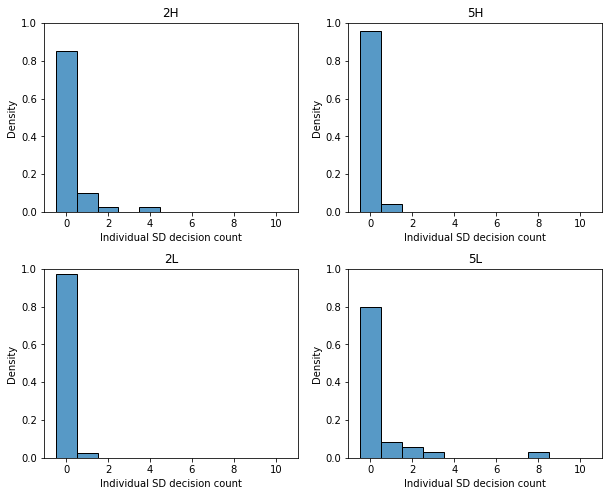

In [28]:
plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.subplot(2, 2, 1)
bidderSDDist(2, 0.019, rmin=3, rmax=30, qmin=0, qmax=1)
plt.subplot(2, 2, 3)
bidderSDDist(2, 0.009, rmin=3, rmax=30, qmin=0, qmax=1)
plt.subplot(2, 2, 2)
bidderSDDist(5, 0.019, rmin=3, rmax=30, qmin=0, qmax=1)
plt.subplot(2, 2, 4)
bidderSDDist(5, 0.009, rmin=3, rmax=30, qmin=0, qmax=1)

In [29]:
def bidderWDDist(n, b, rmin, rmax, qmin, qmax, tol):
    dabovelist, cbelowlist, cabovelist, ebelowlist, eabovelist = [], [], [], [], []
    tmpdict = dictBidderWD(n, b, rmin, rmax, qmin, qmax, tol)
    for key in tmpdict.keys():
        if tmpdict[key]["num_all_dbid"] > 0:
            dabovelist.append(tmpdict[key]["num_wd_dbid"])
            # dabovelist.append(tmpdict[key]["num_wd_dbid"] / tmpdict[key]["num_all_dbid"])
        else:
            dabovelist.append(0)
        if tmpdict[key]["num_all_cleave"] > 0:
            cbelowlist.append(tmpdict[key]["num_cleave_below"] / tmpdict[key]["num_all_cleave"])
        else:
            cbelowlist.append(0)
        if tmpdict[key]["num_all_cbid"] > 0:
            cabovelist.append(tmpdict[key]["num_cbid_above"] / tmpdict[key]["num_all_cbid"])
        else:
            cabovelist.append(0)
        if tmpdict[key]["num_all_eleave"] > 0:
            ebelowlist.append(tmpdict[key]["num_eleave_below"] / tmpdict[key]["num_all_eleave"])
        else:
            ebelowlist.append(0)
        if tmpdict[key]["num_all_eleave"] > 0:
            eabovelist.append(tmpdict[key]["num_eleave_above"] / tmpdict[key]["num_all_eleave"])
        else:
            eabovelist.append(0)
    plt.subplot(1, 3, 1)
    sns.histplot(dabovelist, bins=np.arange(-0.5, 11, 1), stat="density", label="dutch bid above")
    plt.xlabel("Individual WD decision count")
    plt.ylim(0, 1)
    plt.legend()
    plt.subplot(1, 3, 2)
    sns.histplot(cbelowlist, bins=np.arange(0, 1.1, 0.1), stat="density", label="contest leave below", edgecolor=None, alpha=0.4)
    sns.histplot(cabovelist, bins=np.arange(0, 1.1, 0.1), stat="density", label="contest bid above", element="step", fill=False)
    plt.xlabel("WD ratio")
    plt.ylim(0, 10)
    plt.legend()
    plt.subplot(1, 3, 3)
    sns.histplot(ebelowlist, bins=np.arange(0, 1.1, 0.1), stat="density", label="english leave below", edgecolor=None, alpha=0.4)
    sns.histplot(eabovelist, bins=np.arange(0, 1.1, 0.1), stat="density", label="english leave early", element="step", fill=False)
    plt.xlabel("WD ratio")
    plt.ylim(0, 10)
    plt.legend()
    plt.suptitle(str(n) + ("L" if b == 0.009 else "H"))

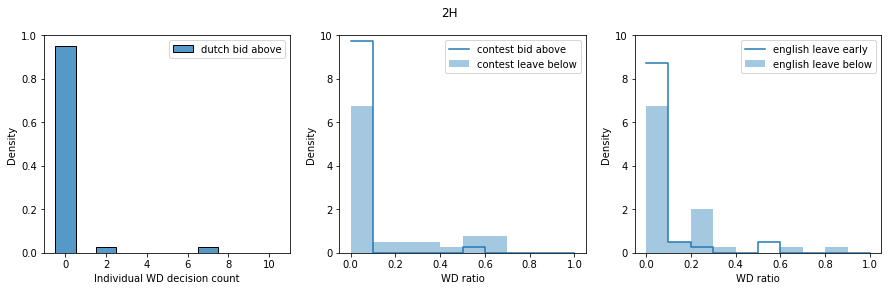

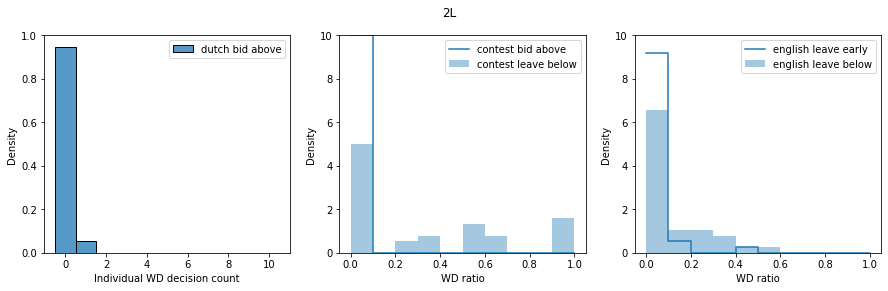

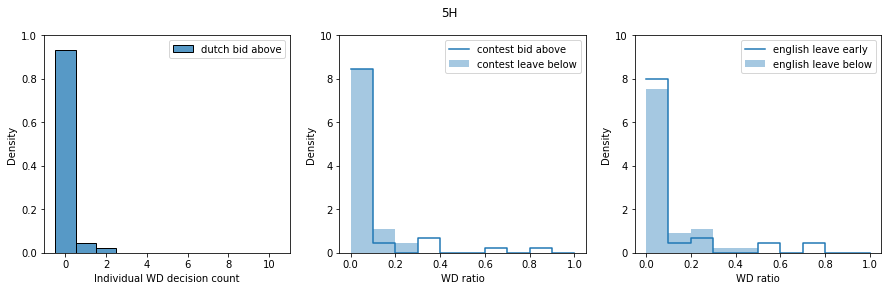

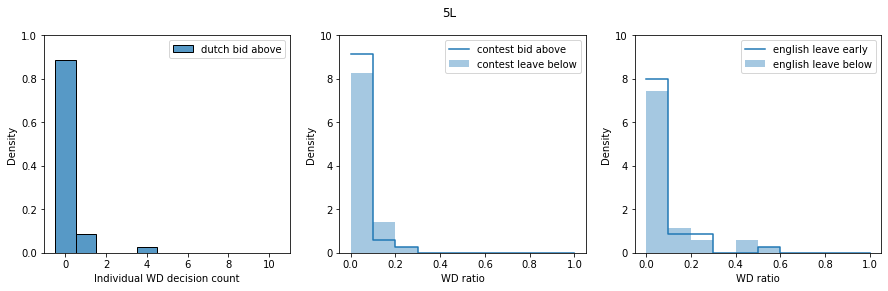

In [30]:
plt.figure(figsize=(15, 4))
bidderWDDist(2, 0.019, rmin=3, rmax=30, qmin=0, qmax=1, tol=2)
plt.figure(figsize=(15, 4))
bidderWDDist(2, 0.009, rmin=3, rmax=30, qmin=0, qmax=1, tol=2)
plt.figure(figsize=(15, 4))
bidderWDDist(5, 0.019, rmin=3, rmax=30, qmin=0, qmax=1, tol=2)
plt.figure(figsize=(15, 4))
bidderWDDist(5, 0.009, rmin=3, rmax=30, qmin=0, qmax=1, tol=2)

In [10]:
def countAlwaysRational(n, b, rmin, rmax, qmin, qmax, tol, counttol):
    tmpdictSD = dictBidderSD(n, b, rmin, rmax, qmin, qmax)
    tmpdictWD = dictBidderWD(n, b, rmin, rmax, qmin, qmax, tol)
    num_noSDWD = 0
    num_all = len(tmpdictSD.keys())
    for key in tmpdictSD.keys():
        if (tmpdictSD[key]["num_sd_bid"] <= counttol) & (tmpdictWD[key]["num_wd_dbid"] <= counttol) & (tmpdictWD[key]["num_cleave_below"] <= counttol) & (tmpdictWD[key]["num_cbid_above"] <= counttol) & (tmpdictWD[key]["num_eleave_below"] <= counttol) & (tmpdictWD[key]["num_eleave_above"] <= counttol):
            num_noSDWD += 1
    print(str(n) + ("L" if b == 0.009 else "H") + "\trational\tall")
    print("\t%d\t\t%d" % (num_noSDWD, num_all))

In [11]:
countAlwaysRational(2, 0.019, rmin=3, rmax=30, qmin=0, qmax=1, tol=2, counttol=1)
countAlwaysRational(2, 0.009, rmin=3, rmax=30, qmin=0, qmax=1, tol=2, counttol=1)
countAlwaysRational(5, 0.019, rmin=3, rmax=30, qmin=0, qmax=1, tol=2, counttol=1)
countAlwaysRational(5, 0.009, rmin=3, rmax=30, qmin=0, qmax=1, tol=2, counttol=1)

2H	rational	all
	24		40
2L	rational	all
	20		38
5H	rational	all
	28		45
5L	rational	all
	19		35
